# Active Learning project

In [1]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

from copy import deepcopy
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling, RandomSampling
from skactiveml.utils import call_func
from sklearn.datasets import load_digits
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from torch import nn

from scipy.stats import bernoulli
import random

mlp.rcParams["figure.facecolor"] = "white"

MISSING_LABEL = -1
RANDOM_STATE = 0
FONTSIZE = 20

torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

warnings.filterwarnings("ignore")

### Load digit data set from Sklearn

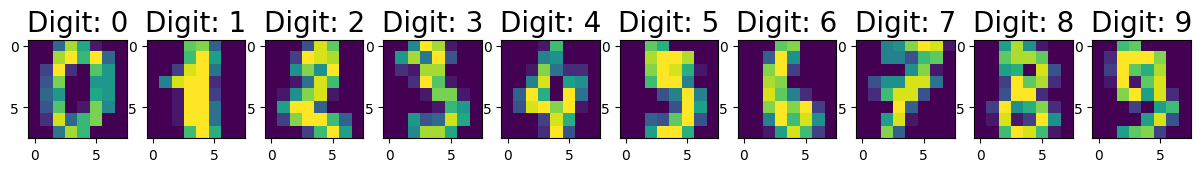

In [2]:
X, y_true = load_digits(return_X_y=True)

# Visualize first 10 images.
fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=10)
for i in range(10):
    axes[i].set_title(f'Digit: {y_true[i]}', fontsize=FONTSIZE)
    axes[i].imshow(X[i].reshape((8, 8)))
plt.show()

X = StandardScaler().fit_transform(X)
X = X.reshape((len(X), 1, 8, 8))
X, y_true = X.astype(np.float32), y_true.astype(np.int64)

classes = np.unique(y_true)

# Make a 66-34 train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y_true, train_size=0.66, random_state=RANDOM_STATE)

### CNN Ensemble
define a convolutional neural network ensemble consisting of multiple base CNNs with different learning rates and initializations.

In [3]:
# Define base module.
class ClassifierModule(nn.Module):
    def __init__(self):
        super(ClassifierModule, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dense_layer = nn.Linear(288, len(classes))
        self.outpout = nn.Softmax(dim=-1)

    def forward(self, X):
        X = self.conv_layer(X)
        X = X.reshape(X.size(0), -1)
        X= self.dense_layer(X)
        X = self.outpout(X)
        return X

# Create list of three base CNNs.
learning_rates = [1.e-3, 1.e-2, 1.e-1]
estimators = []
for i, learning_rate in enumerate(learning_rates):
    net = NeuralNetClassifier(
        ClassifierModule,
        max_epochs=100,
        lr=learning_rate,
        verbose=0,
        train_split=False,
    )
    net.initialize()
    estimators.append((f'clf {i}',
                       SklearnClassifier(
                           estimator=net, missing_label=MISSING_LABEL,
                           random_state=i, classes=classes)
                       )
                      )

# Creat voting ensemble out of given ensemble list.
ensemble_init = SklearnClassifier(
    estimator=VotingClassifier(estimators=estimators, voting='soft'),
    missing_label=MISSING_LABEL, random_state=RANDOM_STATE, classes=classes
)

### Active classification

In [4]:
def change_label(y_expert, p):
    """Change label according to probability p."""
    z = bernoulli.rvs(p, size=1)[-1]
    if z == 1:
        return y_expert
    return random.randint(0, 9)

In [5]:
def train_and_eval(runs, X_train, y, ensemble_init, n_cycles, p, qs):
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)
    # Array to store accuracy of each cycle for each run.
    runs_acc_list = []
    
    for run in range(runs):
        print(f"Run {run + 1} of {runs}")

        # Array to store accuracy of each cycle.
        acc_list = np.zeros(n_cycles + 1)

        # Copy initial ensemble model.
        ensemble = deepcopy(ensemble_init)

        # Create array of missing labels as initial labels.
        y = np.full_like(y_train, fill_value=MISSING_LABEL, dtype=np.int64)

        # Execute active learning cycle.
        for c in range(n_cycles):
            # Fit and evaluate ensemble.
            acc = ensemble.fit(X_train, y).score(X_test, y_test)
            acc_list[c] = acc

            # Select and update training data.
            query_idx = call_func(
                    qs.query, X=X_train, y=y, clf=ensemble, fit_clf=False, ensemble=ensemble,
                    fit_ensemble=False, batch_size=1
            )

            y[query_idx] = change_label(y_train[query_idx], p)

        # Fit and evaluate ensemble last time.
        ensemble.fit(X_train, y)
        acc_list[n_cycles] = ensemble.score(X_test, y_test)

        # Store accuracy of each cycle for each run.
        runs_acc_list.append(acc_list)

    return runs_acc_list

In [6]:
# Define setup.
# n_cycles = 150
# runs = 5
# p_list = np.linspace(0, 1, 11)
# query_techniuqes = [UncertaintySampling(random_state=RANDOM_STATE, missing_label=MISSING_LABEL),
#                     RandomSampling(random_state=RANDOM_STATE, missing_label=MISSING_LABEL)]

# for qs in query_techniuqes:
#     folder_name = 'results/US' if isinstance(qs, UncertaintySampling) else 'results/RS'
#     for p in p_list:
#         file_name = f'{folder_name}/us_p{round(p*100)}.csv' if isinstance(qs, UncertaintySampling) else f'{folder_name}/rs_p{round(p*100)}.csv'
        
#         # Run active learning experiment. And save to csv file.
#         results = train_and_eval(runs, X_train, y_train, ensemble_init, n_cycles, p, qs)
#         np.savetxt(file_name, results, delimiter=',')
#         print(f"Results saved to {file_name}")

### Visualize Results
In the following, I plot the obtained learning curves including the accuracy and area under learning curve (AULC) scores per query strategy.

In [28]:
def visualize_acc_individual(file_name):
    """Visualize accuracy of each cycle averaged over all runs."""
    file = np.loadtxt(f'{file_name}', delimiter=',')
    cycles = np.arange(150 + 1, dtype=int)
    plt.figure(figsize=(16, 9))

    # Average over all runs.
    acc_list = np.array(file).mean(axis=0)
    plt.plot(cycles, acc_list, label=f'AULC={round(acc_list.mean(), 2)}, acc={round(acc_list[-1], 2)}', linewidth=4)
    # Add error bars.
    acc_list = np.array(file)
    plt.fill_between(cycles, acc_list.mean(axis=0) - acc_list.std(axis=0),
                     acc_list.mean(axis=0) + acc_list.std(axis=0), alpha=0.2)
    
    plt.grid()
    plt.xticks(cycles[::10], fontsize=FONTSIZE)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=FONTSIZE)
    plt.xlabel('# cycle', fontsize=FONTSIZE)
    plt.ylabel('test accuracy', fontsize=FONTSIZE)
    plt.legend(loc='lower right', fontsize='x-large')
    plt.show()


# Visualize accuracy of each cycle averaged over all runs. Take as input a folder name with csv files.
# Create an average line for each csv file in the folder and plot it in one figure.
def visualize_acc_folder(qs_name):
    """Visualize accuracy of each cycle averaged over all runs."""
    if qs_name == 'US':
        title = 'Uncertainty Sampling'
        file_name_start = 'us_p'
    elif qs_name == 'RS':
        title = 'Random Sampling'
        file_name_start = 'rs_p'
     
    p_list = np.linspace(0, 1, 6)
    cycles = np.arange(150 + 1, dtype=int)
    plt.figure(figsize=(10, 8))
    
    for p in p_list:
        acc_list = np.loadtxt(f'results/{qs_name}/{file_name_start}{round(p*100)}.csv', delimiter=',').mean(axis=0)
        plt.plot(cycles, acc_list, label=f'P={round(p, 2)}', linewidth=4)
        # Add error bars.
        acc_list = np.loadtxt(f'results/{qs_name}/{file_name_start}{round(p*100)}.csv', delimiter=',')
        plt.fill_between(cycles, acc_list.mean(axis=0) - acc_list.std(axis=0),
                        acc_list.mean(axis=0) + acc_list.std(axis=0), alpha=0.2)
    
    plt.grid()
    plt.xticks(cycles[::15], fontsize=FONTSIZE)
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=FONTSIZE)
    plt.xlabel('# of queries', fontsize=FONTSIZE)
    plt.ylabel('test accuracy', fontsize=FONTSIZE)
    # invert the legend order
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='upper left', fontsize='x-large')
    plt.title(f'{title}', fontsize=FONTSIZE)
    plt.show()

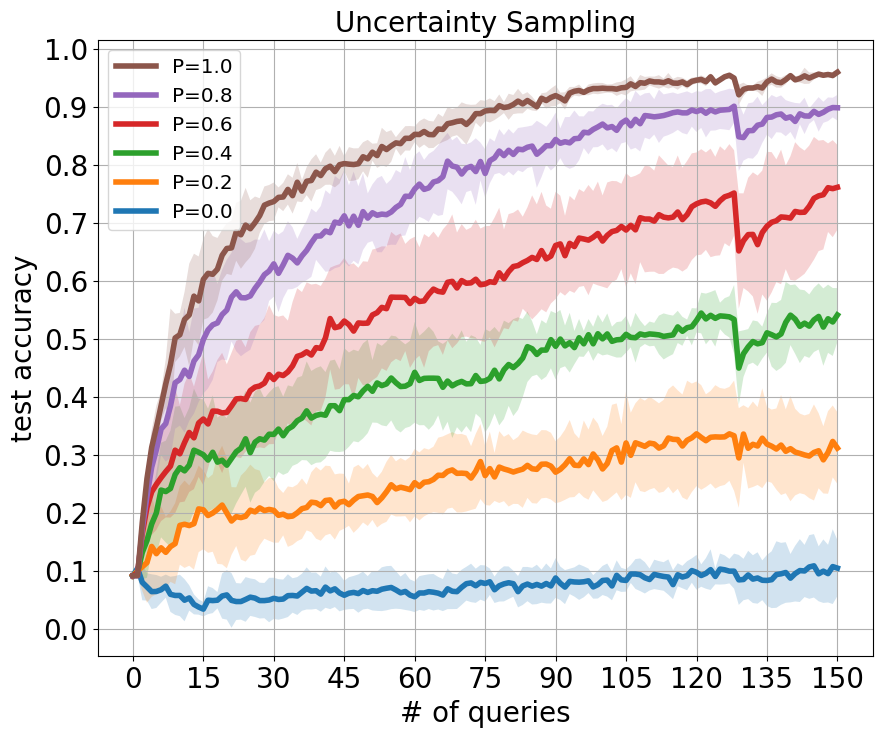

In [29]:
# visualize_acc_individual('results/RS/rs_p70.csv')
visualize_acc_folder('US')

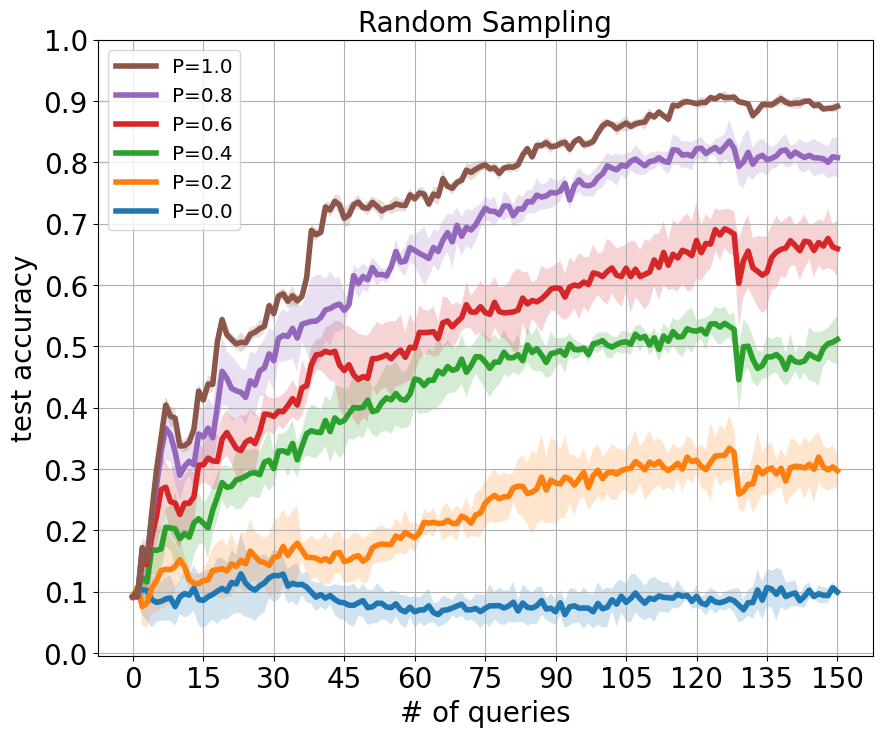

In [30]:
visualize_acc_folder('RS')

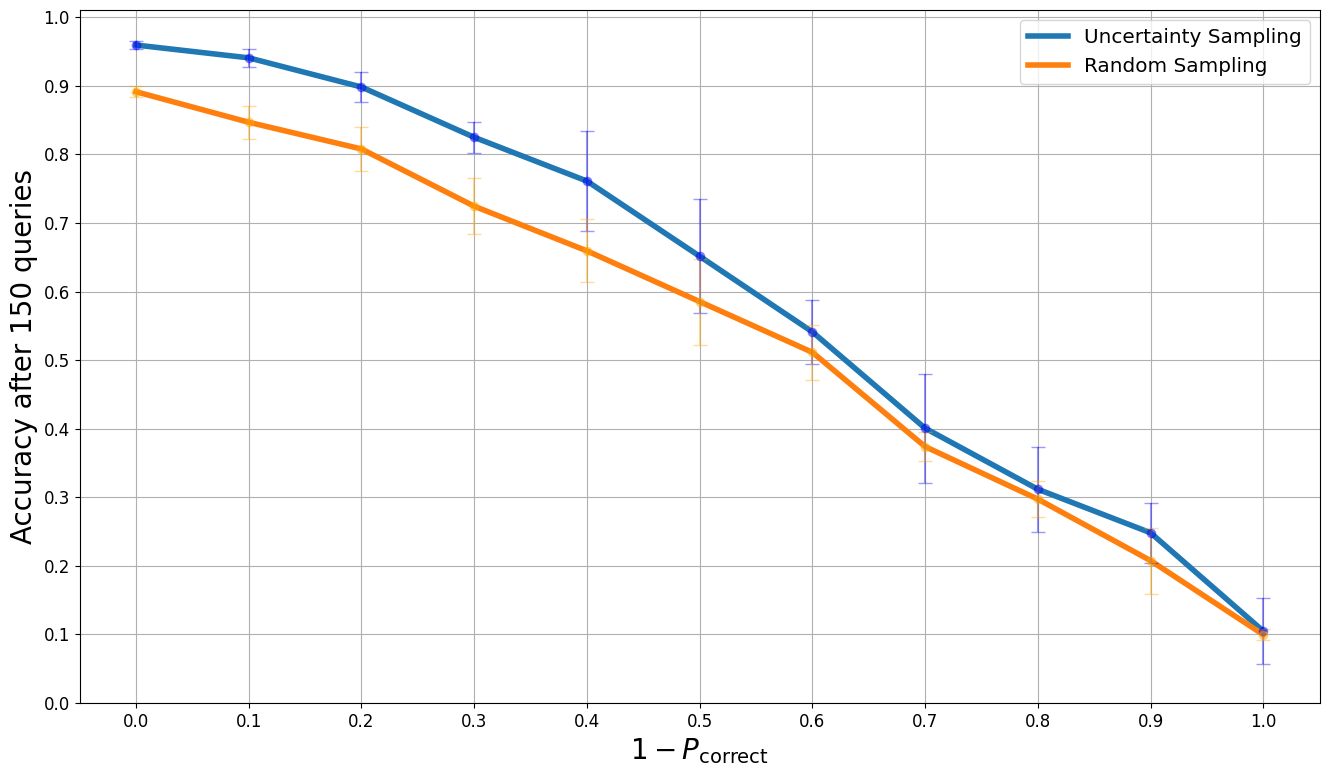

In [18]:
# Create table from both results folders. Where each row is a different p value and each column is a different query strategy.
def create_table():
    p_list = np.linspace(0, 1, 11)
    table = np.zeros((len(p_list), 4))
    for i, p in enumerate(p_list):
        table[i, 0] = np.loadtxt(f'results/US/us_p{round(p*100)}.csv', delimiter=',').mean(axis=0)[-1]
        table[i, 1] = np.loadtxt(f'results/RS/rs_p{round(p*100)}.csv', delimiter=',').mean(axis=0)[-1]
        # add error bars to table
        acc_list = np.loadtxt(f'results/US/us_p{round(p*100)}.csv', delimiter=',')
        table[i, 2] = acc_list.std(axis=0)[-1]
        acc_list = np.loadtxt(f'results/RS/rs_p{round(p*100)}.csv', delimiter=',')
        table[i, 3] = acc_list.std(axis=0)[-1]
    return table

table = create_table()
# Plot table.
plt.figure(figsize=(16, 9))
plt.plot(np.linspace(1, 0, 11), table[:, 0], label='Uncertainty Sampling', linewidth=4)
plt.plot(np.linspace(1, 0, 11), table[:, 1], label='Random Sampling', linewidth=4)
# Add error bars using the values from the table.
plt.errorbar(np.linspace(1, 0, 11), table[:, 0], yerr=table[:, 2], fmt='o', capsize=5, color='blue', alpha=0.4)
plt.errorbar(np.linspace(1, 0, 11), table[:, 1], yerr=table[:, 3], fmt='o', capsize=5, color='orange', alpha=0.4)


plt.grid()
plt.xticks(np.linspace(0, 1, 11), fontsize='large', rotation=0)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize='large')
plt.xlabel('$1-P_{\mathrm{correct}}$', fontsize=FONTSIZE)
plt.ylabel('Accuracy after 150 queries', fontsize=FONTSIZE)
plt.legend(loc='upper right', fontsize='x-large')
plt.show()


In [165]:
# Create table with  difference between both query strategies to table.
diff = table[:, 0].reshape(-1, 1) - table[:, 1].reshape(-1, 1)
diff

array([[0.00523732],
       [0.0405892 ],
       [0.01440262],
       [0.02684124],
       [0.02978723],
       [0.06612111],
       [0.10180033],
       [0.100491  ],
       [0.0903437 ],
       [0.09394435],
       [0.06808511]])